**1. Setting Up the Environment**

In [1]:
# Install necessary libraries
!pip install kagglehub

# Import required libraries
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage import exposure

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

**2. Data Preparation**

a. Mount Google Drive and Download Dataset

In [2]:
from google.colab import files
files.upload()  # Select the 'kaggle.json' file from your local system

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivareddy5152","key":"78f06a2ec3218b37153d20825000fafb"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
100% 2.70G/2.70G [00:37<00:00, 93.7MB/s]
100% 2.70G/2.70G [00:37<00:00, 77.3MB/s]


In [5]:
dataset_path = '/content/New Plant Diseases Dataset(Augmented)'

b. Organize Dataset into Train and Validation Folders

In [6]:
train_directory = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/'
validation_directory = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/'

In [7]:
def ensure_class_in_validation(train_dir, val_dir, class_name, num_images=10):
    # Paths for the class in training and validation directories
    train_class_path = os.path.join(train_dir, class_name)
    val_class_path = os.path.join(val_dir, class_name)

    # Create the class directory in validation if it doesn't exist
    if not os.path.exists(val_class_path):
        os.makedirs(val_class_path)

    # Count images in the validation class directory
    val_images_count = len(os.listdir(val_class_path))

    # Calculate the number of images to add if count is below the required number
    missing_images_count = num_images - val_images_count
    if missing_images_count > 0:
        # Select random images from the training class folder
        train_images = os.listdir(train_class_path)
        images_to_copy = random.sample(train_images, min(missing_images_count, len(train_images)))

        # Copy selected images to the validation directory
        for img_name in images_to_copy:
            src_path = os.path.join(train_class_path, img_name)
            dst_path = os.path.join(val_class_path, img_name)
            shutil.copy(src_path, dst_path)
        print(f"Added {missing_images_count} images to the '{class_name}' class in the validation set.")
    else:
        print(f"The '{class_name}' class in the validation set already has sufficient images.")

In [8]:
# List of class names (ensure this matches the folder names in your dataset)
class_names = os.listdir(train_directory)

# Ensure each class in validation set has at least 10 images
for class_name in class_names:
    ensure_class_in_validation(train_directory, validation_directory, class_name, num_images=10)

The 'Cherry_(including_sour)___healthy' class in the validation set already has sufficient images.
The 'Tomato___Bacterial_spot' class in the validation set already has sufficient images.
The 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' class in the validation set already has sufficient images.
The 'Tomato___Tomato_mosaic_virus' class in the validation set already has sufficient images.
The 'Orange___Haunglongbing_(Citrus_greening)' class in the validation set already has sufficient images.
The 'Tomato___Late_blight' class in the validation set already has sufficient images.
The 'Grape___healthy' class in the validation set already has sufficient images.
The 'Blueberry___healthy' class in the validation set already has sufficient images.
The 'Peach___Bacterial_spot' class in the validation set already has sufficient images.
The 'Apple___Apple_scab' class in the validation set already has sufficient images.
The 'Pepper,_bell___Bacterial_spot' class in the validation set already has suff

c. Load Image Paths and Labels into a DataFrame

In [9]:
# Initialize lists to hold image paths and labels
image_files = []
labels = []

In [10]:
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.jpg', '.png')):
            file_path = os.path.join(root, file)
            image_files.append(file_path)
            labels.append(os.path.basename(root))

In [11]:
# Create a DataFrame
df = pd.DataFrame({'image_path': image_files, 'label': labels})

# Display the first few rows
print(df.head())

                                          image_path                 label
0  /content/New Plant Diseases Dataset(Augmented)...  Tomato___Late_blight
1  /content/New Plant Diseases Dataset(Augmented)...  Tomato___Late_blight
2  /content/New Plant Diseases Dataset(Augmented)...  Tomato___Late_blight
3  /content/New Plant Diseases Dataset(Augmented)...  Tomato___Late_blight
4  /content/New Plant Diseases Dataset(Augmented)...  Tomato___Late_blight


In [12]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 image_path    0
label         0
dtype: int64


In [13]:
# Check for duplicate rows
duplicates_count = df.duplicated().sum()
print("Number of Duplicate Rows:", duplicates_count)

# Display duplicate rows if any
if duplicates_count > 0:
    print("Duplicate Rows:\n", df[df.duplicated()])


Number of Duplicate Rows: 0


**3. Image Preprocessing**

a. Define Image Preprocessing Function

In [14]:
def preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Convert to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Check image shape
    if img_rgb.shape[:2] != target_size:
        img_rgb = cv2.resize(img_rgb, target_size, interpolation=cv2.INTER_LINEAR)

    # Create figure with 3 subplots for each channel
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    channels = ['Red', 'Green', 'Blue']
    for i, ax in enumerate(axes):
        ax.imshow(img_rgb[:, :, i], cmap='gray')
        ax.set_title(f"{channels[i]} Channel")
        ax.axis('off')
    plt.show()

    # Plot histogram of pixel intensities
    plt.figure(figsize=(10, 4))
    plt.hist(img_rgb.ravel(), bins=256, color='gray', alpha=0.5)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

    # Image Manipulation Techniques
    # Sharpening
    kernel_sharpen = np.array([[0, -1, 0],
                               [-1, 5,-1],
                               [0, -1, 0]])
    img_sharpen = cv2.filter2D(img_rgb, -1, kernel_sharpen)

    # Blurring
    img_blur = cv2.GaussianBlur(img_sharpen, (5, 5), 0)

    # Brightness and Contrast Adjustment
    alpha = 1.2  # Contrast control
    beta = 30    # Brightness control
    img_bright_contrast = cv2.convertScaleAbs(img_blur, alpha=alpha, beta=beta)

    # Adding Noise (Salt and Pepper)
    noise = np.random.randint(0, 50, (target_size[0], target_size[1], 3), dtype='uint8')
    img_noisy = cv2.add(img_bright_contrast, noise)

    return img_noisy

b. Apply Preprocessing to Sample Image

In [15]:
# Select a sample image
sample_image_path = df['image_path'].iloc[0]
print(f"Sample Image Path: {sample_image_path}")

Sample Image Path: /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/Tomato___Late_blight/d63639eb-4a20-4321-b8b6-38de563a1ee6___GHLB_PS Leaf 26.4 Day 13.jpg


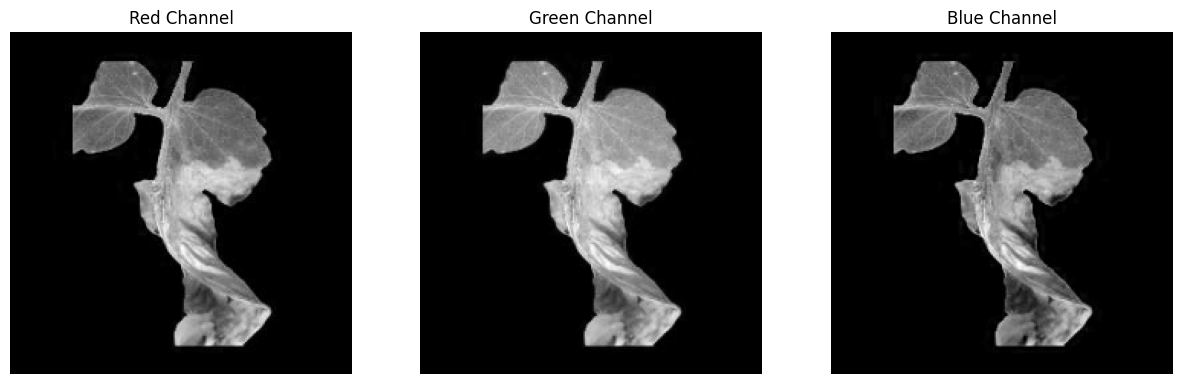

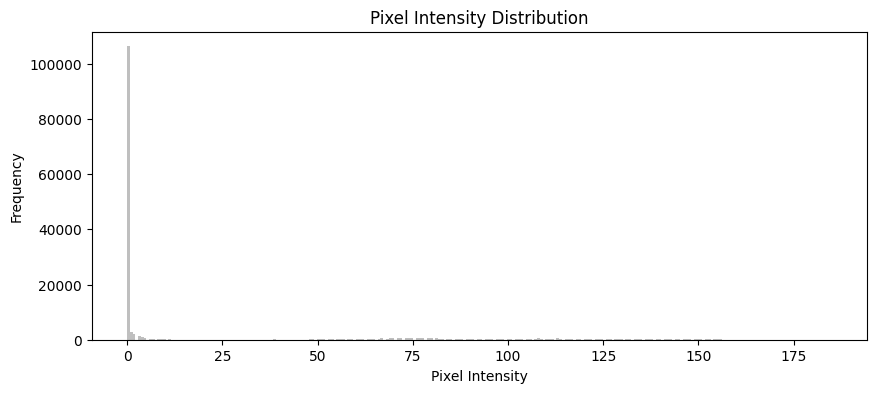

In [16]:
# Preprocess the image
preprocessed_image = preprocess_image(sample_image_path)

**4. Setting Up ImageDataGenerators for Data Augmentation**

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=40, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224, 224),  # or whatever size your model requires
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    validation_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [19]:
print("Training class indices:", train_generator.class_indices)
print("Validation class indices:", validation_generator.class_indices)

Training class indices: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___L

**5. Image Segmentation using OpenCV**

In [20]:
# Function to segment the image
def segment_image(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(image)
    cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)
    segmented_img = cv2.bitwise_and(image, mask)
    return segmented_img

Example for segmentation

In [21]:
# Path to the train directory
train_directory = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'

# List contents of the train directory
try:
    train_contents = os.listdir(train_directory)
    print("Contents of the train directory:", train_contents)
except FileNotFoundError as e:
    print("Directory not found:", e)

Contents of the train directory: ['Cherry_(including_sour)___healthy', 'Tomato___Bacterial_spot', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Tomato___Tomato_mosaic_virus', 'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Late_blight', 'Grape___healthy', 'Blueberry___healthy', 'Peach___Bacterial_spot', 'Apple___Apple_scab', 'Pepper,_bell___Bacterial_spot', 'Squash___Powdery_mildew', 'Grape___Black_rot', 'Tomato___Leaf_Mold', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Apple___Cedar_apple_rust', 'Potato___healthy', 'Potato___Late_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Raspberry___healthy', 'Tomato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Strawberry___Leaf_scorch', 'Apple___Black_rot', 'Corn_(maize)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___healthy', 'Tomato___Septoria_leaf_spot', 'Pepper,_bell___healthy', 'Tomato___Target_Spot', 'Grape___Esca_(Black_Measles)', 'Apple___healthy', 'Cherry_(including_sour)___Powder

Image path: /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Corn_(maize)___healthy/9b6f7782-2244-4575-8226-d5083c2d0223___R.S_HL 8144 copy_flipLR.jpg


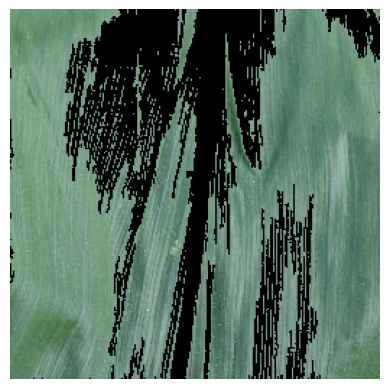

In [22]:
folder_name = 'Corn_(maize)___healthy'  # Adjust this based on the output of previous steps
folder_path = os.path.join(train_directory, folder_name)

# List the image files in the directory
try:
    image_files = os.listdir(folder_path)

    # Ensure that there are images in the folder
    if image_files:
        # Select a random image file or choose the first one
        random_image_file = random.choice(image_files)  # or use image_files[0]

        # Create the full path to the image
        image_path = os.path.join(folder_path, random_image_file)

        # Print the image path for debugging
        print("Image path:", image_path)

        # Check if the image exists
        if os.path.exists(image_path):
            # Function for segmenting the image
            def segment_image(image_path):
                # Read the image
                image = cv2.imread(image_path)
                if image is None:
                    print(f"Error: Could not read image {image_path}")
                    return None
                # Converting to grayscale
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                # Applying a binary threshold to get a binary image
                _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

                # Finding contours
                contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # Creating a mask for the segmented image
                mask = np.zeros_like(image)
                cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

                # Applying the mask to get the segmented image
                segmented_img = cv2.bitwise_and(image, mask)

                return segmented_img

            # Call the segmentation function
            segmented_img = segment_image(image_path)

            # Check if the image was segmented successfully
            if segmented_img is not None:
                plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.show()
        else:
            print(f"Image file does not exist: {image_path}")
    else:
        print("No images found in the specified directory.")
except FileNotFoundError as e:
    print("Directory not found:", e)

Visual Validation

In [23]:
# Select a few random images for validation
num_images_to_display = 5  # Number of images you want to validate
random_images = random.sample(image_files, min(num_images_to_display, len(image_files)))

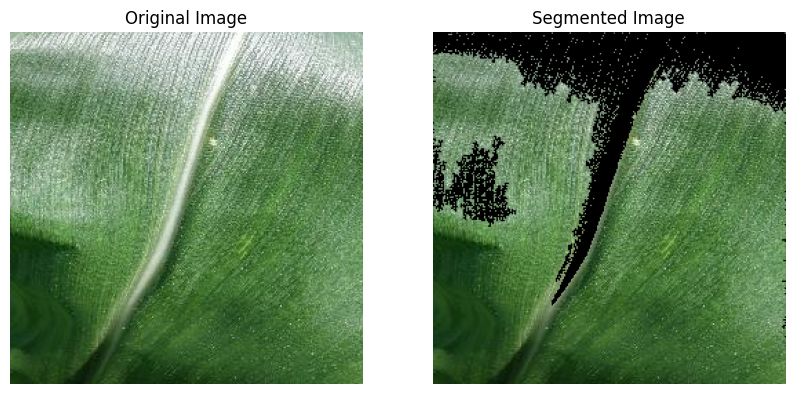

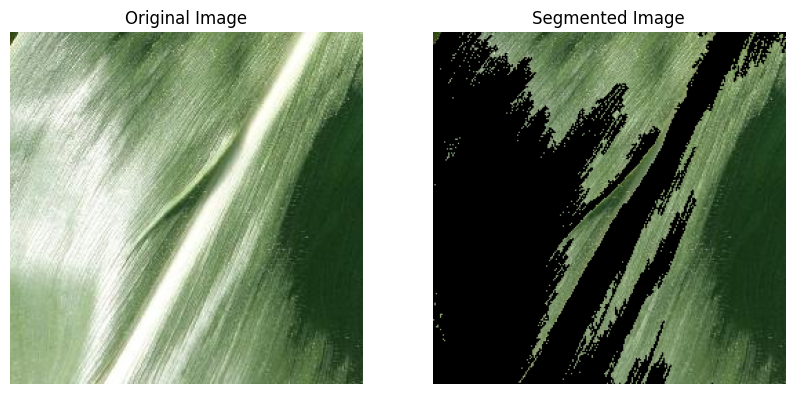

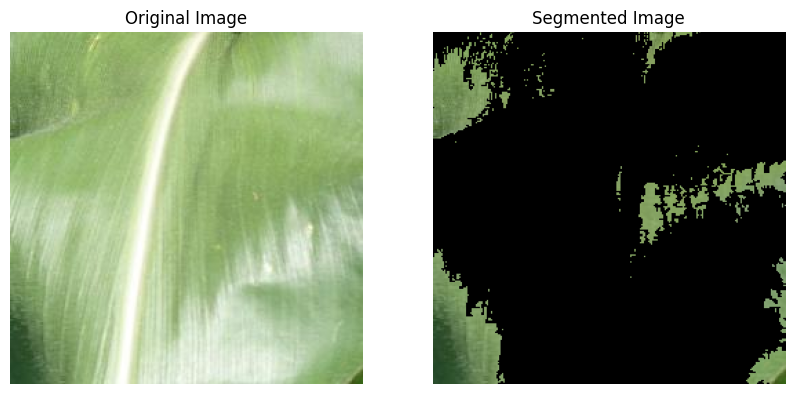

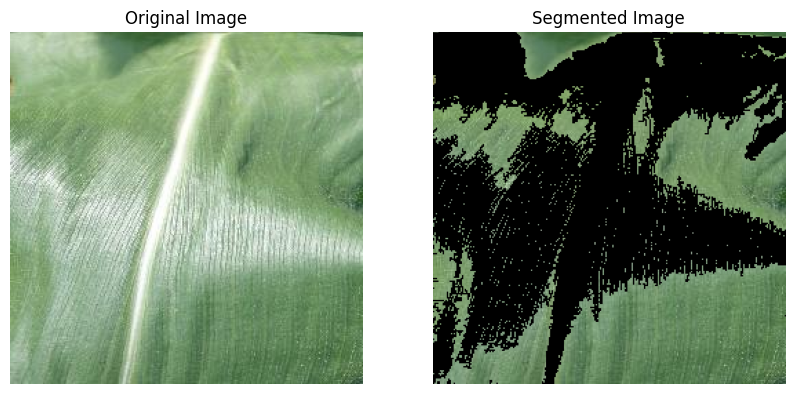

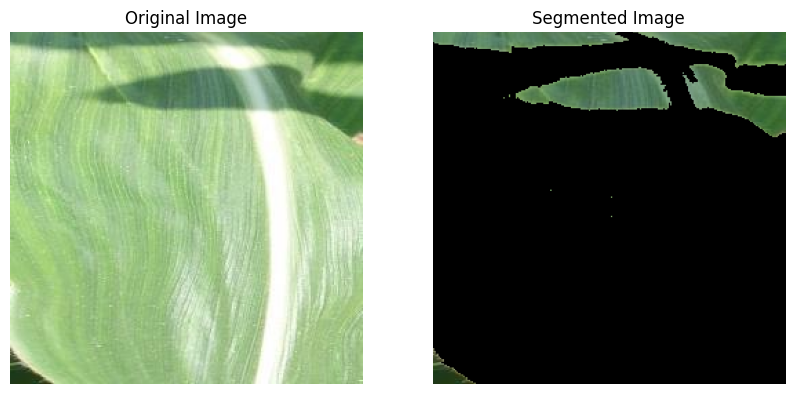

In [24]:
# Loop through the selected images
for image_file in random_images:
    image_path = os.path.join(folder_path, image_file)

    # Segment the image
    segmented_img = segment_image(image_path)

    # Validate the results by displaying the original and segmented images
    original_img = cv2.imread(image_path)

    if segmented_img is not None:
        plt.figure(figsize=(10, 5))

        # Display original image
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        # Display segmented image
        plt.subplot(1, 2, 2)
        plt.title('Segmented Image')
        plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        plt.show()

**6. Feature Engineering with Edge Detection**

a. Define Feature Extraction Function

In [25]:
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.io import imread

def extract_features(image_path):
    # Load the image
    image = imread(image_path)

    # Convert to grayscale (HOG works on grayscale images)
    if image.ndim == 3:  # Check if the image is RGB
        image = rgb2gray(image)

    # Extract HOG features
    features = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys'
    )

    return features

b. Apply Feature Extraction to the Entire Dataset

In [26]:
# Extract features for all images
feature_list = []
labels = []

for index, row in df.iterrows():
    image_path = row['image_path']
    label = row['label']
    try:
        features = extract_features(image_path)
        feature_list.append(features)
        labels.append(label)
    except FileNotFoundError as e:
        print(e)

In [27]:
# Convert to DataFrame
feature_df = pd.DataFrame(feature_list)
feature_df['label'] = labels

In [28]:
# Display the first few rows
print(feature_df.head())

     0    1    2    3    4    5    6    7    8    9  ...  34587  34588  34589  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0   

   34590  34591  34592  34593  34594  34595                 label  
0    0.0    0.0    0.0    0.0    0.0    0.0  Tomato___Late_blight  
1    0.0    0.0    0.0    0.0    0.0    0.0  Tomato___Late_blight  
2    0.0    0.0    0.0    0.0    0.0    0.0  Tomato___Late_blight  
3    0.0    0.0    0.0    0.0    0.0    0.0  Tomato___Late_blight  
4    0.0    0.0    0.0    0.0    0.0    0.0  Tomato___Late_blight  

[5 rows x 34597 columns]


**5. Model Configuration and Training**

a. Prepare Data for Training

In [29]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [30]:
# Encode the labels as integers
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)

# One-hot encode the integer-encoded labels
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# Verify the one-hot encoded labels
print("One-hot encoded labels:\n", onehot_encoded[:5])

One-hot encoded labels:
 [[0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


In [31]:
# Split the data
X = feature_df.drop('label', axis=1)
y = onehot_encoded

# Split without stratification
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])
print("Number of classes:", y_train.shape[1])

Training samples: 2436
Validation samples: 610
Number of classes: 8


b. Define the Model

In [33]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, concatenate
from tensorflow.keras.models import Model

In [34]:
# Define image input
image_input = Input(shape=(224, 224, 3), name='image_input')

In [35]:
# Load pre-trained DenseNet without top layers
base_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=image_input)
base_model.trainable = False  # Freeze the base model

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [36]:
# Add global average pooling
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

In [37]:
# Define feature input
feature_input = Input(shape=(X_train.shape[1],), name='feature_input')
f = Dense(128, activation='relu')(feature_input)
f = Dropout(0.5)(f)

In [38]:
# Concatenate CNN and manual features
combined = concatenate([x, f])

In [39]:
# Add final classification layers
z = Dense(256, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(y_train.shape[1], activation='softmax')(z)

In [40]:
# Define the model
model = Model(inputs=[image_input, feature_input], outputs=output)

In [41]:
# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ image_input[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 12,156,872 (46.37 MB)

 Trainable params: 5,119,368 (19.53 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

c. Data Generators for Image Data

In [43]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [44]:
# Function to load and preprocess images
def load_images(image_paths, target_size=(224, 224)):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize
        images.append(img_array)
    return np.array(images)

In [45]:
# Load training and validation images
train_image_paths = X_train.index.tolist()
val_image_paths = X_val.index.tolist()

In [46]:
X_train_images = load_images(df.loc[X_train.index, 'image_path'].values)
X_val_images = load_images(df.loc[X_val.index, 'image_path'].values)

In [47]:
print("Training Images Shape:", X_train_images.shape)
print("Validation Images Shape:", X_val_images.shape)

Training Images Shape: (2436, 224, 224, 3)
Validation Images Shape: (610, 224, 224, 3)


d. Train the model

In [48]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

In [49]:
# Train the model
history = model.fit(
    [X_train_images, X_train.values],
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=([X_val_images, X_val.values], y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 440s 6s/step - accuracy: 0.7652 - loss: 0.9810 - val_accuracy: 0.9656 - val_loss: 0.0984 - learning_rate: 0.0010
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 425s 5s/step - accuracy: 0.9522 - loss: 0.1285 - val_accuracy: 0.9803 - val_loss: 0.0664 - learning_rate: 0.0010
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 392s 5s/step - accuracy: 0.9765 - loss: 0.0716 - val_accuracy: 0.9803 - val_loss: 0.0594 - learning_rate: 0.0010
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 461s 5s/step - accuracy: 0.9718 - loss: 0.0707 - val_accuracy: 0.9803 - val_loss: 0.0658 - learning_rate: 0.0010
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 401s 5s/step - accuracy: 0.9910 - loss: 0.0330 - val_accuracy: 0.9672 - val_loss: 0.0879 - learning_rate: 0.0010
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 436s 5s/step - accuracy: 0.9781 - loss: 0.0542 - val_accuracy: 0.9836 - val_loss: 0.0550 - learning_rate: 0.0010
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 555s 7s/step - accuracy: 0.9816 - loss: 0.0473 - val_acc

**6. Model Evaluation and Finalization**

a. Evaluate the Model

In [50]:
# Evaluate on validation set
val_loss, val_accuracy = model.evaluate([X_val_images, X_val.values], y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.9853 - loss: 0.0533
Validation Loss: 0.046487677842378616
Validation Accuracy: 0.9868852496147156


b. Save the Model

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
model.save('/content/drive/My Drive/PlantAI_Project.keras')

c. Visualize Training and Validation Metrics

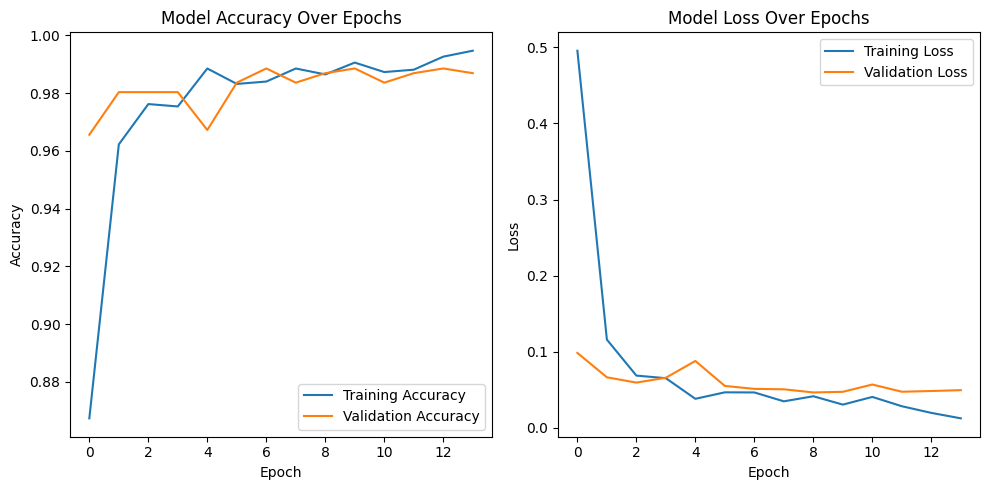

In [60]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()